## Step 1: Prepare the Data

In [149]:
import matplotlib
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches  # Added for rectangular patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycirclize import Circos

# Making SVGs "Editable"
matplotlib.rcParams["svg.fonttype"] = "none"

# 1. Prepare the Data
df = pd.read_csv("data/weighted_high_corr_adjacency_matrix.csv", index_col=0)

### REORDERING NODES: Distribute similar degrees across the circle ###
# Calculate degrees
node_degrees = (df > 0).sum(axis=1)

# we use an interleaving algorithm so that similar degrees are distributed across the circle
# Sort nodes by degree (degree 1 -> degree 4)
sorted_nodes = node_degrees.sort_values().index.tolist()

# Interleave the list: Pick one from the start, then one from the middle
# This ensures that high-degree nodes are separated by low-degree nodes
n = len(sorted_nodes)
reordered_nodes = []
half = n // 2
for i in range(half):
    reordered_nodes.append(sorted_nodes[i])
    reordered_nodes.append(sorted_nodes[i + half])
if n % 2 != 0:  # Handle odd numbered list
    reordered_nodes.append(sorted_nodes[-1])

# Use this new order for the rest of the script
nodes = reordered_nodes

# 2. distribute node manually for better posioning (The order here determines the position on the circle)
nodes = [
    "1-methylhistidine",
    "Proline betaine",
    "3-methylhistidine",
    "Stearoylcarnitine",
    "Caffeine",
    "Palmitoylcarnitine",
    "Inosine",
    "Hexanoylcarnitine",
    "Hypoxanthine",
    "Hexadecenoylcarnitine",
    "N1-methyl-2-pyridone-5-carboxamide",
    "Hydroxydecanoylcarnitine",
    "N-methyl proline",
    "Octanoylcarnitine",
    "Linoleoylcarnitine",
    "Tetradecadienoylcarnitine",
    "Paraxanthine",
    "Tetradecanoylcarnitine",
    "N1-methyl-4-pyridone-3-carboxamide",
    "Oleoylcarnitine",
]

# Prepare Links based on the reordered nodes
links = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        weight = df.loc[nodes[i], nodes[j]]
        if weight > 0:
            links.append({"from": nodes[i], "to": nodes[j], "weight": weight})
links_df = pd.DataFrame(links)

### CUSTOM DISCRETE GRADIENT ###
# Pick a colormap (Greens, Blues, Oranges, Purples, etc.)
base_cmap = plt.get_cmap("Greens")

# Sample 4 colors from the colormap.
# We start at 0.3 (to avoid white) and end at 0.9 (deepest green)
degree_colors = {
    1: base_cmap(0.39),  # Light Green
    2: base_cmap(0.59),  # Medium-Light
    3: base_cmap(0.79),  # Medium-Dark
    4: base_cmap(0.99),  # Darkest Green
}

# Define visual properties
# degree_color_map = {1: "#3498db", 2: "#2ecc71", 3: "#f39c12", 4: "#e74c3c"}
degree_size_map = {1: 200, 2: 450, 3: 700 * 2, 4: 1000 * 3.5}
degree_labels = {1: "Degree 1", 2: "Degree 2", 3: "Degree 3", 4: "Degree 4"}

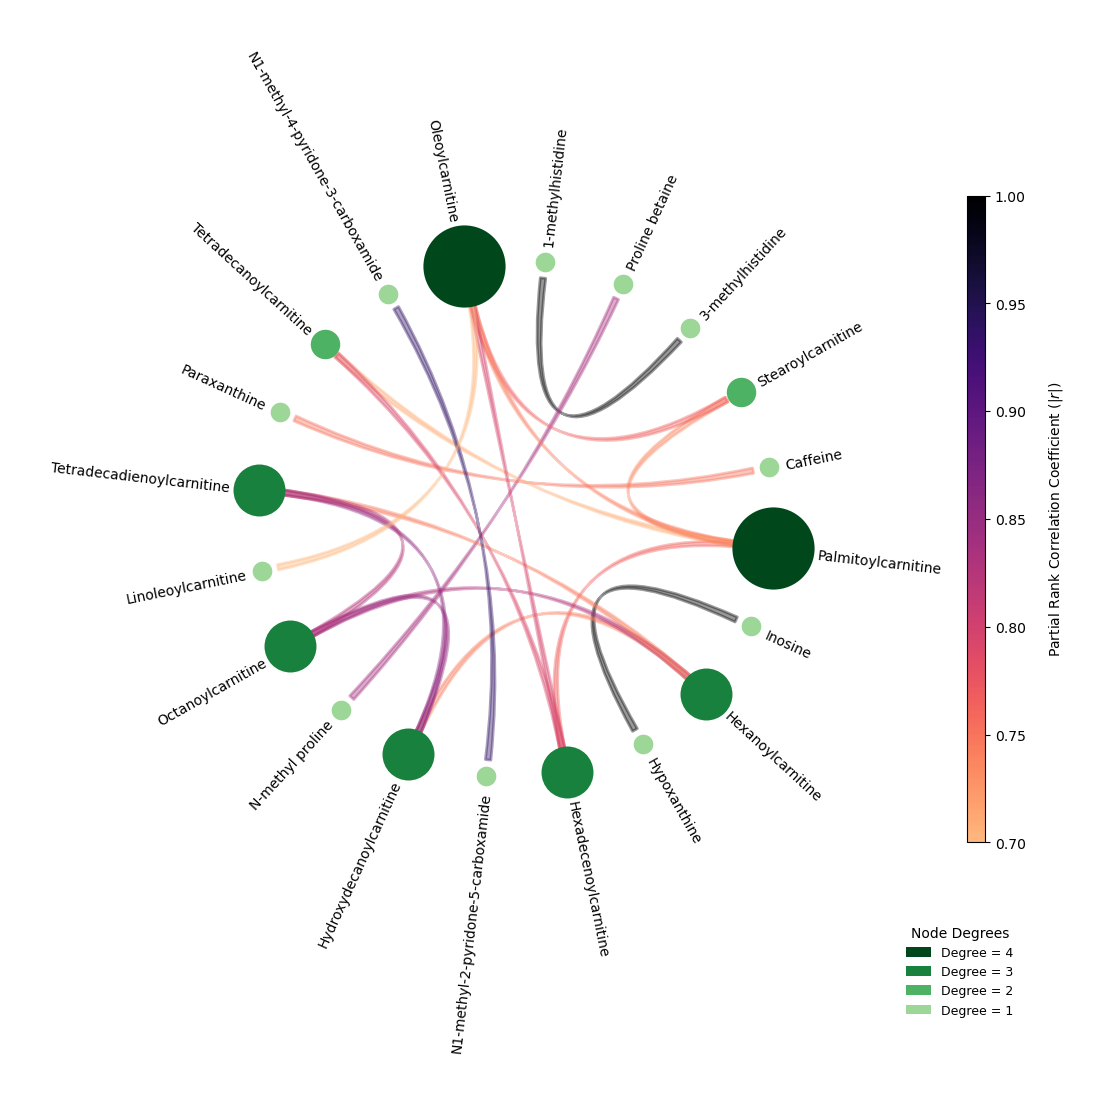

In [150]:
# 2. Initialize Circos
sectors = {node: 1 for node in nodes}
circos = Circos(sectors, space=5)

# 3. Create Figure
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={"projection": "polar"})

### CUSTOMIZE COLORMAP ###
# Get the original reversed magma
original_magma_r = plt.get_cmap("magma_r", 256)  # Use 256 colors for better granularity


# Truncate the first 15% (this removes the brightest yellow and starts at a deeper gold)
# Then sample 256 colors from that starting point to the end (black)
truncated_colors = original_magma_r(np.linspace(0.15, 1.0, 256))
custom_magma_r = mcolors.ListedColormap(truncated_colors)

cmap_links = custom_magma_r
norm_links = colors.Normalize(vmin=0.7, vmax=1.0)

# 4. Plot Nodes and Labels
for sector in circos.sectors:
    ### REDUCE SIZE: Using radius 75-80 instead of 95-100 ###
    track = sector.add_track((75, 80))

    deg = node_degrees[sector.name]
    # node_color = degree_color_map.get(deg, "#95a5a6")
    node_color = degree_colors[deg]
    node_size = degree_size_map.get(deg)

    # Place node circle at the center of the track (radius 77.5)
    track.scatter(
        [0.5], [77.5], color=node_color, s=node_size, edgecolor="black", zorder=10
    )

    # Calculate dynamic radius based on degree to keep padding consistent
    # Larger degrees get a slightly larger radius offset
    padding_offsets = {1: 3, 2: 4, 3: 7, 4: 12}
    dynamic_r = 82 + padding_offsets.get(deg, 5)

    # Ray-like (Radial) Labels
    sector.text(
        sector.name,
        r=dynamic_r,  # Placed just outside the nodes
        size=10,
        orientation="vertical",
        va="center",
        ha="left",
        adjust_rotation=True,
    )

# 5. Plot Non-Ribbon Links
for _, link in links_df.iterrows():
    color = cmap_links(norm_links(link["weight"]))

    ### FIX: Radius r1 and r2 must be separate arguments, not inside the tuple ###
    circos.link(
        (link["from"], 0.45, 0.55),  # Region 1 (Source)
        (link["to"], 0.45, 0.55),  # Region 2 (Target)
        r1=75,  # Radius for end 1
        r2=75,  # Radius for end 2
        color=color,
        alpha=0.4,
        linewidth=2,
    )

# 6. Render the plot
circos.plotfig(ax=ax)

# 7. Colorbar
sm = cm.ScalarMappable(cmap=cmap_links, norm=norm_links)
sm.set_array([])

# INCREASE pad to add space on the left of the colorbar
cbar = fig.colorbar(
    sm,
    ax=ax,
    orientation="vertical",
    shrink=0.7,  # Controls vertical height
    aspect=35,  # INCREASED from 20 to 35 to make it thinner
    pad=0.12,  # Distance from the labels
)

cbar.set_label(
    r"Partial Rank Correlation Coefficient ($|r|$)", fontsize=10, labelpad=15
)

legend_patches = [
    mpatches.Patch(facecolor=degree_colors[d], label=f"Degree = {d}")
    for d in [4, 3, 2, 1]
]

# Add the legend to the bottom right
# bbox_to_anchor coordinates (x, y):
# x > 1.0 moves it further right. y < 0.2 moves it further down.
ax.legend(
    handles=legend_patches,
    loc=4,
    bbox_to_anchor=(1.25, -0.25),
    frameon=False,
    fontsize=9,
    title="Node Degrees",
    title_fontsize=10,
    handlelength=2,  # Makes the rectangles slightly longer (=== style)
    handleheight=0.8,
)
### SIMPLE RECTANGULAR LEGEND END ###

ax.set_axis_off()

# Save as a high-quality PNG for quick viewing/sharing
plt.savefig(
    "img/fig_S3A_high_corr_customized_chord.png",
    bbox_inches="tight",
    dpi=300,
    pad_inches=0.05,
)

# Save as an SVG for publication and high-resolution printing
plt.savefig(
    "img/fig_S3A_high_corr_customized_chord.svg", bbox_inches="tight", pad_inches=0.05
)

plt.show()